In [10]:
from Functions import *
from Optimizations import *
from utils import *
from Saving import *

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import time

In [3]:
f = flat_sharp_gaussian
grad_f = grad_flat_sharp_gaussian

x_range = [-25, 25]

In [12]:
A = np.array([[1]])
b = np.array([0])
f = QuadraticFunctionInit(A, b)
grad_f = GradQuadraticFunctionInit(A)

x_range = [-15, 15]

In [13]:
def resample_positions_softmax(weights, positions, beta=1):
    probabilities = softmax(weights, beta)
    pos_filter = np.random.choice(list(range(len(positions))), len(positions), p=probabilities)
    return np.array(positions)[np.array(pos_filter)]

def softmax(weights, beta=1):
    sum_exp_weights = sum([np.exp(beta*w) for w in weights])
    probabilities = np.array([np.exp(beta*w) for w in weights]) / sum_exp_weights
    return probabilities

In [32]:
def weight_function(U, grad_U, x, curr_weights, gamma=0.9):
    return gamma * curr_weights + np.linalg.norm(grad_U(x.T), axis=0)

num_particles = 1000
process = {}
process["start"] = [[np.random.uniform(x_range[0], x_range[1])] for _ in range(num_particles)]
process["gamma"] = lambda t: 0.05
process["temperature"] = lambda t: 0.01
process["epsilon"] = 0
process["weight_function"] = weight_function

process["resample_function"] = lambda w, end_p: resample_positions_softmax(w, end_p, beta=-0.01) #
# process["resample_function"] =  lambda w, end_p: end_p # 
all_paths = diffusion_resampling(f, grad_f, process, 20, 25, domain_enforcer=hyper_cube_enforcer(x_range[0], x_range[1], 0.2))


In [33]:
X = np.linspace(x_range[0], x_range[1], 200)
inp = np.array([X])
Y = f(inp)

all_paths_proc = []

for t in range(len(all_paths)):
    curr_paths = all_paths[t]
    
    all_paths_proc.append([])
    
    for p in range(len(curr_paths)):
        x_curr = np.array(curr_paths[p])
        out = f(x_curr.T)
        all_paths_proc[-1].append(np.concatenate([x_curr, out.reshape(len(out), 1)], axis=1))

all_paths_proc = np.array(all_paths_proc)

In [55]:
# Approximating density with the particles
def V(x, K, particles):
    N = len(particles)
    for p in particles:
        ret_sum += K(x, p)
    return 1 / float(N) * ret_sum

ValueError: operands could not be broadcast together with shapes (1000,) (1,200) 

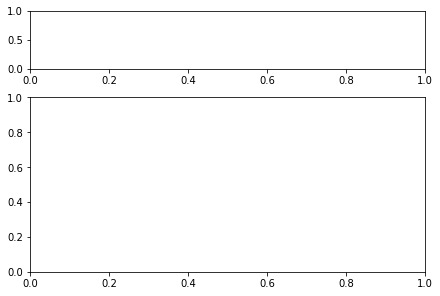

In [56]:
a = time.time()
K = multi_gaussian(np.array([[0.6]]))


ani_path = create_animation_1d_pictures_particles(all_paths_proc, X, Y, graph_details={"p_size": 3, #"density_function": None})
                                                                                      "density_function": 
                                                                                      lambda x, p: V(np.array([x]), K, p)})

print(time.time() - a)

In [ ]:
164.994313955307
147.84000778198242


In [40]:
create_animation(ani_path, "test.mp4", framerate=15)

### Things to note:

The beta value of the softmax turns out to be very important. Adjusting that value determines how much to value each respective shallow/flat regions. Seems like changing it can give you a nice stationary distribution around certain falt minima. 

Also the tau value is important. Letting the run run for too long will cause the particles to approach more or less the stationary distribution if ran with soley diffusion. 

Maybe penalize where you started from. 

